# Entropia {#sec-entropy}

**Prerequisiti**

- Per i concetti di base sulla teoria dell'informazione, si rimanda ai primi due capitoli di  *Information Theory: A Tutorial Introduction* [@stone2022information].

**Concetti e competenze chiave**

- Comprendere e sapere calcolare l'informazione si Shannon.
- Comprendere e sapere calcolare l'entropia per variabili casuali discrete.
- Comprendere il concetto di entropia per variabili casuali continue.

**Preparazione del Notebook**

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import kl_div
import math
from collections import Counter
from scipy.stats import entropy
import heapq
from collections import defaultdict

In [6]:
# Funzione per calcolare la lunghezza media del codice di Huffman
def huffman_encoding(probabilities):
    # Coda con priorità (min-heap) per costruire l'albero di Huffman
    heap = [[weight, [symbol, ""]] for symbol, weight in probabilities.items()]
    heapq.heapify(heap)

    # Costruzione dell'albero di Huffman
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = "0" + pair[1]
        for pair in hi[1:]:
            pair[1] = "1" + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Dizionario dei codici di Huffman
    huffman_dict = sorted(heapq.heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

    # Calcolo della lunghezza media del codice
    avg_length = 0
    for symbol, code in huffman_dict:
        avg_length += probabilities[symbol] * len(code)

    return avg_length, huffman_dict

## Introduzione {.unnumbered}

> Information is the resolution of uncertainty.  
> (Shannon C, 1948)

In questo capitolo, descriveremo il concetto di *entropia*, una misura fondamentale sviluppata nell'ambito della teoria dell'informazione. L'entropia ci permette di quantificare l'incertezza associata a una distribuzione di probabilità e, di conseguenza, la quantità di informazione che un evento ci fornisce. 

L'entropia è legata alla nostra capacità di prevedere l'esito di un evento: più un risultato è imprevedibile, maggiore sarà l'entropia. In termini più generali, l'entropia di una variabile casuale misura quanto è incerto o "sorprendente" il valore che essa assumerà in media. Se ogni possibile esito ha la stessa probabilità di verificarsi, l'entropia sarà massima. Se invece alcuni esiti sono molto più probabili di altri, l'entropia diminuirà, poiché l'incertezza complessiva è ridotta.

Un'intuizione sull'entropia può essere ottenuta considerando il seguente esempio. Pensiamo a un sacchetto di palline colorate. Se il sacchetto contiene solo palline di un unico colore, possiamo essere sicuri di quale pallina estrarremo ogni volta. Non c'è alcuna incertezza o sorpresa, quindi l'entropia è pari a zero. Tuttavia, se il sacchetto contiene un numero uguale di palline di diversi colori, ogni estrazione è un'incognita: l'incertezza è massima e, di conseguenza, lo è anche l'entropia.

Il concetto di entropia va ben oltre questo semplice esempio. Esso si applica a qualunque situazione in cui ci sia un insieme di risultati possibili con probabilità diverse. In questo capitolo, ci concentreremo sul significato matematico dell'entropia, esplorando come può essere calcolata per diverse distribuzioni di probabilità e come essa si collega alla quantità di informazione che un sistema può fornire. Inizieremo con esempi semplici, come l'entropia di una moneta equa o di un dado, per poi estendere il concetto a situazioni più complesse.

## Che cos'è l'Informazione?

L'informazione è solitamente misurata in bit, e un bit di informazione permette di scegliere tra due alternative ugualmente probabili. La parola bit deriva da *binary digit* (cioè uno zero o un uno).

Per capire come l'informazione possa essere misurata in bit, consideriamo il seguente esempio discusso da @stone2022information. Immagina di trovarti ad un incrocio e di dover scegliere una strada tra due possibilità. Ogni volta che incontri un incrocio, devi prendere una decisione: andare a destra o a sinistra. Ogni decisione può essere rappresentata da un bit di informazione: 0 per sinistra, 1 per destra.

Consideriamo un percorso con più incroci, come quello rappresentato nell'immagine. Ogni percorso completo può essere codificato da una sequenza di bit, dove ogni bit corrisponde ad una decisione presa in un incrocio. Ad esempio, per raggiungere il punto D011, la sequenza di bit corretta è 011.

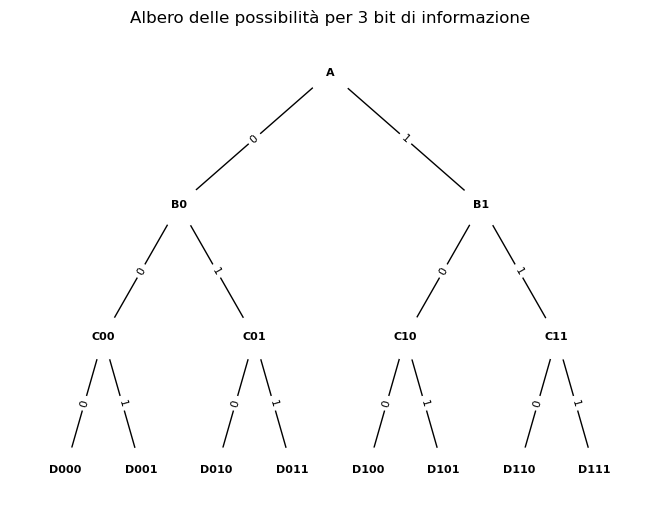

In [4]:
#| echo: false

# Crea un grafo diretto
G = nx.DiGraph()

# Aggiungi i nodi e archi per l'albero binario a 3 livelli
edges = [
    ("A", "B0", "0"),
    ("A", "B1", "1"),
    ("B0", "C00", "0"),
    ("B0", "C01", "1"),
    ("B1", "C10", "0"),
    ("B1", "C11", "1"),
    ("C00", "D000", "0"),
    ("C00", "D001", "1"),
    ("C01", "D010", "0"),
    ("C01", "D011", "1"),
    ("C10", "D100", "0"),
    ("C10", "D101", "1"),
    ("C11", "D110", "0"),
    ("C11", "D111", "1"),
]

# Aggiungi gli archi con etichette
for edge in edges:
    G.add_edge(edge[0], edge[1], label=edge[2])

# Posizionamento dei nodi per una visualizzazione ad albero
pos = {
    "A": (0, 0),
    "B0": (-2, -1),
    "B1": (2, -1),
    "C00": (-3, -2),
    "C01": (-1, -2),
    "C10": (1, -2),
    "C11": (3, -2),
    "D000": (-3.5, -3),
    "D001": (-2.5, -3),
    "D010": (-1.5, -3),
    "D011": (-0.5, -3),
    "D100": (0.5, -3),
    "D101": (1.5, -3),
    "D110": (2.5, -3),
    "D111": (3.5, -3),
}

# Disegna il grafo
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1000,
    node_color="white",
    font_size=8,
    font_weight="bold",
    edge_color="black",
    arrows=False,
)

# Aggiungi le etichette degli archi (0 o 1)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Mostra il grafo
plt.title("Albero delle possibilità per 3 bit di informazione")
plt.show()

**Quanti bit sono necessari per identificare una destinazione specifica?**
 
Ogni bit raddoppia il numero di possibili percorsi. Quindi, se abbiamo $n$ bit, possiamo identificare $2^n$ destinazioni distinte. Viceversa, se conosciamo il numero di destinazioni $m$, possiamo calcolare il numero di bit necessari utilizzando la formula:

$$
n = \log_2 m.
$$

Nel nostro esempio, abbiamo 8 destinazioni finali. Pertanto, sono necessari $\log_2 8 = 3$ bit per identificarne una in modo univoco.

**Cosa rappresenta un bit in questo contesto?**

Un bit rappresenta un'unità elementare di informazione. In questo caso, ogni bit risponde alla domanda: "Devo andare a destra o a sinistra?". 

**Perché utilizziamo i logaritmi?**

Il logaritmo in base 2 ci permette di calcolare l'esponente a cui elevare 2 per ottenere un dato numero. In altre parole, ci dice quanti bit sono necessari per rappresentare un certo numero di destinazioni. Per l'esempio considerato, per arrivare a $D011$ partendo da $A$, sono necessarie 3 domande la cui risposta binaria è destra/sinistra.

In sintesi, esiste una relazione diretta tra il numero di bit di informazione e il numero di possibili destinazioni in un percorso decisionale binario. Ogni bit ci permette di fare una scelta tra due alternative, raddoppiando così il numero di possibili percorsi. 

Per ricapitolare:

- Abbiamo visto che per raggiungere il punto D011 partendo da A, abbiamo bisogno di prendere tre decisioni binarie (sinistra o destra) in corrispondenza di tre incroci.
- Ogni decisione binaria può essere rappresentata da un bit (0 o 1). Quindi, per l'intero percorso, abbiamo bisogno di una sequenza di tre bit: 011.
- Per rispondere alla domanda "Come andare da A a D011?", abbiamo dunque bisogno di 3 bit di informazione.

## La Sorpresa e l'Informazione di Shannon

Nel primo esempio, abbiamo visto come l'informazione possa essere misurata in bit, dove ogni bit corrisponde a una decisione binaria che ci aiuta a raggiungere una destinazione specifica in un percorso. Tuttavia, la quantità di informazione può variare anche in base alla probabilità con cui certi eventi o scelte si verificano. È qui che entra in gioco il concetto di **informazione di Shannon**, che prende in considerazione la sorpresa associata a un risultato.

Immaginiamo, ad esempio, di avere una moneta che cade testa il 90% delle volte. Poiché il risultato "testa" è molto probabile, non ci sorprenderebbe molto ottenerlo. Al contrario, il risultato "croce", che accade solo il 10% delle volte, ci sorprenderà di più. Più improbabile è un risultato, maggiore sarà la sorpresa nel vederlo.

In termini di informazione, possiamo dire che risultati meno probabili forniscono più informazione, perché ci sorprendono di più. Una prima idea per misurare questa sorpresa è definirla come inversamente proporzionale alla probabilità del risultato: $1/p(x)$. Tuttavia, Shannon ha dimostrato che è più utile esprimere la sorpresa come il logaritmo di $1/p(x)$. Questo ci porta alla definizione dell'informazione di Shannon, che si misura in bit (se usiamo il logaritmo in base 2, lo stesso utilizzato per misurare i percorsi nel primo esempio). L'informazione di Shannon per un risultato $x$ è quindi:

$$
h(x) = \log_2 \frac{1}{p(x)} = -\log_2 p(x) \text{ bit}.
$$ {#eq-surprise-shannon}

In questo modo, vediamo che l'informazione associata a un evento dipende dalla sua probabilità: eventi meno probabili portano più informazione, e viceversa.

## Sorpresa e Probabilità

Per comprendere pienamente la sorpresa, dobbiamo conoscere le probabilità dei diversi risultati. Questo significa che l'informazione di Shannon dipende dalla distribuzione di probabilità $p(X)$ della variabile aleatoria $X$. In altre parole, per misurare quanta informazione otteniamo da un risultato, dobbiamo sapere quanto è probabile ciascun possibile esito.

Un modo per stimare queste probabilità è osservare i risultati di un esperimento ripetuto nel tempo. Utilizzando le osservazioni, possiamo stimare la probabilità di ciascun risultato e quindi calcolare l'informazione di Shannon associata. Questo approccio ci permette di collegare il concetto di informazione misurata in bit (come nel primo esempio sugli incroci) con la sorpresa generata da eventi più o meno probabili.

## Entropia come Media dell'Informazione di Shannon

Quando si lavora con fenomeni aleatori, spesso non ci interessa solo la sorpresa associata a un singolo risultato, ma piuttosto la sorpresa **media** che si può ottenere considerando tutti i possibili risultati di una variabile. Questa sorpresa media è chiamata **entropia** e si indica con $H(X)$. L'entropia ci dà una misura della quantità di incertezza (o informazione potenziale) contenuta in una variabile aleatoria $X$, la cui distribuzione di probabilità è data da $p(X)$.

L'entropia rappresenta quindi la quantità media di informazione che otteniamo osservando i risultati della variabile $X$. Se, ad esempio, lanciamo una moneta molte volte, l'entropia della distribuzione dei risultati riflette la media delle informazioni di Shannon ottenute da ciascun lancio. In altre parole, ci dice quanto ci aspettiamo di "imparare" in media da ogni lancio.

Matematicamente, l'entropia può essere approssimata dalla media delle informazioni di Shannon associate a ciascun possibile risultato $x_i$:

$$
H(X) \approx \frac{1}{n} \sum_{i=1}^{n} h(x_i).
$$ {#eq-surprise-shannon}

In questa formula, $h(x_i)$ è l'informazione di Shannon di un singolo risultato $x_i$, come discusso in precedenza. L'entropia, quindi, non si riferisce a un evento specifico, ma alla sorpresa **media** che ci aspettiamo quando osserviamo ripetutamente una variabile aleatoria. Più equilibrata è la distribuzione delle probabilità dei risultati (ad esempio, se tutti i risultati sono ugualmente probabili), maggiore sarà l'entropia, perché ciascun risultato fornisce una quantità simile di informazione. Al contrario, se alcuni risultati sono molto più probabili di altri (ad esempio, una moneta truccata che dà quasi sempre "testa"), l'entropia sarà minore, poiché otteniamo meno informazione da ogni osservazione. 

## Entropia di una Moneta Equa

Se una moneta è equa, allora $p(x_h) = 0.5$ e la sorpresa di osservare una testa è

$$
\begin{align}
h(x_h) &= \log_2 \frac{1}{p(x_h)} \notag\\ 
       &= \log_2(1/0.5) = 1 \text{ bit}.\notag
\end{align}
$$

Dato che $p(x_t) = 0.5$, la sorpresa di osservare una testa (o una croce) è di un bit.

Possiamo trovare la sorpresa media lanciando la moneta, diciamo, 100 volte, misurando la sorpresa di ogni risultato e poi calcolando la media dei 100 risultati. Se lanciamo una moneta 100 volte, ci aspettiamo di osservare testa circa 50 volte e croce circa 50 volte. Se osserviamo esattamente 50 teste e 50 croci, la quantità media di sorpresa diventa

$$
\begin{align}
H(X) &= \frac{1}{100} \left( \sum_{i=1}^{50} \log_2 \frac{1}{p(x_h)} + \sum_{i=1}^{50} \log_2 \frac{1}{p(x_t)} \right)\notag\\ 
&=1 \text{ bit per lancio della moneta}\notag.
\end{align}
$$

In sintesi, poiché la quantità di sorpresa o informazione di Shannon fornita dall'osservazione del risultato di ogni lancio di questa moneta equa è di un bit, ne segue che l'informazione media $H(X)$ di ogni lancio è anch'essa di un bit.

### Interpretazione dell'Entropia (1)

Se consideriamo una distribuzione di probabilità uniforme, una variabile con entropia $H(X)$ espressa in bit fornisce sufficiente informazione (nel senso della teoria dell'informazione di Shannon) per distinguere tra $m = 2^{H(X)}$ alternative ugualmente probabili. In altre parole, l'entropia misura la quantità di informazione contenuta in una variabile, esprimendola in termini di quante scelte ugualmente probabili sono possibili per quella variabile.

## Entropia di una moneta sbilanciata

Una moneta sbilanciata ha una quantità media di informazione (o incertezza) inferiore rispetto a una moneta equa. 

La sorpresa associata a testa è:

$$
h(\text{testa}) = \log\left(\frac{1}{0.9}\right) = 0.15 \text{ bit},
$$

mentre la sorpresa associata a croce è maggiore:

$$
h(\text{croce}) = \log\left(\frac{1}{0.1}\right) = 3.32 \text{ bit}.
$$

### Interpretazione dell'Entropia (2)

Se immaginiamo di lanciare la moneta tante volte, la sorpresa media o entropia di questa moneta, considerando considerando $p(\text{testa}) = 0.9$ e $p(\text{croce}) = 0.1$, è:

$$H(X) = 0.9 \log_2 \frac{1}{0.9} + 0.1 \log_2 \frac{1}{0.1} = 0.469 \text{ bit per lancio}.$$

L'incertezza media per questa moneta sbilanciata è dunque inferiore a quella di una moneta equa (che ha un'entropia di 1 bit), anche se l'incertezza associata all'esito meno probabile (croce) è maggiore (3.32 bit) rispetto a quella di una moneta equa (1 bit). In generale, nessuna moneta sbilanciata può avere un'entropia media maggiore di quella di una moneta equa.

Poiché $p(\text{testa}) = 0.9$ e $p(\text{croce}) = 0.1$, possiamo scrivere la formula dell'entropia come:

$$
H(X) = p(\text{testa}) \log\left(\frac{1}{p(\text{testa})}\right) + p(\text{croce}) \log\left(\frac{1}{p(\text{croce})}\right) = 0.469 \text{ bit per lancio}.
$$

Per semplificare ulteriormente, possiamo rappresentare l'entropia sommando sui due possibili esiti (testa e croce):

$$
H(X) = \sum_{i=1}^{2} p(x_i) \log\left(\frac{1}{p(x_i)}\right) = 0.469 \text{ bit per lancio}.
$$

Questa entropia di 0.469 bit implica che l'informazione contenuta in 1.000 lanci di questa moneta potrebbe essere rappresentata usando solo 469 bit binari, cioè $1000 \times 0.469$. 

Possiamo interpretare questo risultato considerando l'entropia nei termini di un numero di alternative ugualmente probabili. La variabile $X$, che rappresenta il lancio della moneta, potrebbe essere vista come equivalente a una variabile che può assumere:

$$
m = 2^{H(X)} = 2^{0.469} \approx 1.38 \text{ valori equiprobabili}.
$$

A prima vista, questo risultato può sembrare strano, dato che stiamo considerando una moneta, che ha solo due  esiti possibili. Tuttavia, interpretare l'entropia nei termini di un numero equivalente di valori ugualmente probabili ci offre un'intuizione sull'informazione rappresentata da una variabile. Un modo per pensare a questo concetto è di immaginare che una moneta con entropia $H(X) = 0.469$ bit abbia la stessa quantità di incertezza di un dado ipotetico con 1.38 facce.

## Caratteristiche dell'Entropia

- **Entropia Massima**: L'entropia raggiunge il suo valore massimo quando tutti gli esiti di un evento hanno la stessa probabilità di verificarsi. In questa situazione, l'incertezza è massima, poiché nessun indizio ci permette di prevedere quale sarà il risultato. Questo rappresenta il massimo grado di imprevedibilità.

- **Entropia Minima**: L'entropia è minima quando l'esito di un evento è completamente certo (con probabilità pari a 1) o impossibile (con probabilità pari a 0). In questi casi, non esiste incertezza né sorpresa, e quindi non c'è alcuna informazione aggiuntiva da ottenere osservando il risultato.

## Additività dell'Entropia per Eventi Indipendenti

L'entropia è additiva nel caso di eventi indipendenti. Ciò significa che, se si verificano due o più eventi indipendenti, l'entropia totale della loro combinazione è pari alla somma delle entropie di ciascun evento considerato singolarmente. Questa proprietà deriva dall'additività dei logaritmi, che permette di sommare le entropie individuali per ottenere l'entropia complessiva.

### Stimare l'Entropia da una Distribuzione di Probabilità

Consideriamo una variabile casuale discreta $X$, che rappresenta una serie di eventi distinti, ciascuno con una probabilità associata. Per una variabile discreta $X$ con possibili valori $x_1, x_2, \dots, x_n$ e una funzione di massa di probabilità $p(x) = \Pr\{X = x\}$, l'entropia $H(X)$ misura l'incertezza complessiva associata a questa distribuzione di probabilità e si calcola con la formula:

$$ 
\begin{equation}
H(X) = -\sum_{x \in X} p(x) \log_2 p(x). 
\end{equation}
$$ {#eq-entropy-collection}

In questo contesto, l'entropia $H(X)$ rappresenta l'incertezza media relativa alla collezione di eventi descritti dalla variabile $X$. La formula fornisce una somma pesata delle sorprese associate a ciascun esito, dove la sorpresa di un risultato $x$ dipende dalla sua improbabilità, calcolata come $-\log_2 p(x)$. Il segno negativo è necessario perché i logaritmi di probabilità, essendo inferiori a 1, sono negativi; il segno negativo li trasforma in valori positivi, che rappresentano correttamente la sorpresa o l'informazione associata.

Ogni termine della somma, $-p(x) \log_2 p(x)$, esprime la quantità di informazione o sorpresa relativa a un singolo evento, ponderata dalla sua probabilità $p(x)$. Quanto più uniformemente distribuite sono le probabilità degli eventi, tanto maggiore sarà l'entropia complessiva. Al contrario, se uno o più eventi sono molto più probabili rispetto agli altri, l'entropia sarà inferiore, riflettendo una minore incertezza.

In sintesi, l'entropia $H(X)$ misura l'incertezza complessiva associata alla distribuzione di probabilità di una variabile casuale discreta $X$. Essa quantifica la sorpresa media che ci si può aspettare quando si osserva un evento estratto casualmente da questa collezione.

::: {#exm-}

Supponiamo di avere un dado con otto facce. Ci sono $m = 8$ esiti possibili:

$$
A_x = \{1,2,3,4,5,6,7,8\}.
$$

Poiché il dado è equo, tutti gli otto esiti hanno la stessa probabilità di $p(x) = 1/8$, definendo così una distribuzione di probabilità uniforme:

$$
p(X) = \left\{\frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}, \frac{1}{8}\right\}.
$$

L'entropia di questa distribuzione può essere calcolata come:

$$
H(X) = - \sum_{i=1}^{8} \frac{1}{8} \log_2 \frac{1}{8} = \log_2 8 = 3 \text{ bit}.
$$

Poiché l'informazione associata a ciascun esito è esattamente 3 bit, anche l'entropia media è di 3 bit, che rappresenta l'incertezza complessiva della variabile $X$.

Dato che $X$ ha un'entropia di $H(X) = 3$ bit, possiamo dire che $X$ può rappresentare fino a:

$$
m = 2^{H(X)} = 2^3 = 8
$$

esiti equiprobabili.

::: 

::: {#exm-}

Sia $X$ una variabile casuale discreta che può assumere i valori $a, b, c,$ e $d$ con una distribuzione di probabilità di massa $p(a) = \frac{1}{2}$, $p(b) = \frac{1}{4}$, $p(c) = \frac{1}{8}$, e $p(d) = \frac{1}{8}$, rispettivamente. L'entropia di $X$, che misura l'incertezza associata alla distribuzione di probabilità, è calcolata come:

$$
H(X) = -\left(\frac{1}{2} \log_2 \frac{1}{2} + \frac{1}{4} \log_2 \frac{1}{4} + \frac{1}{8} \log_2 \frac{1}{8} + \frac{1}{8} \log_2 \frac{1}{8}\right).
$$

Calcolando i singoli termini, otteniamo:

$$
H(X) = -\left(\frac{1}{2} \cdot (-1) + \frac{1}{4} \cdot (-2) + \frac{1}{8} \cdot (-3) + \frac{1}{8} \cdot (-3)\right) = \frac{7}{4} \text{ bits}.
$$

È importante notare che l'entropia $H(X)$ dipende esclusivamente dalla distribuzione di probabilità dei valori di $X$ e non dai valori stessi.

:::

### Stimare l'Entropia in un Campione di Osservazioni

L'entropia può essere calcolata non solo per distribuzioni teoriche, ma anche per campioni di dati osservati. In questo caso, l'entropia ci fornisce una misura di quanto sia incerta o imprevedibile la distribuzione dei valori all'interno del campione.

::: {#exm-}
Per comprendere meglio questo concetto, possiamo calcolare l'entropia associata a insiemi di osservazioni. Consideriamo i due vettori seguenti: 

$$
\begin{align}
x &= \{1, 2, 3, 3, 3, 3, 2, 1, 3, 3, 2, 1, 1, 4, 4, 3, 1, 2\}, \notag\\
y &= \{3, 4, 1, 1, 1, 1, 4, 3, 1, 1, 4, 3, 3, 2, 2, 1, 3, 4\}. \notag
\end{align}
$$

Troviamo l'entropia associata a ciascuno di essi.

In [5]:
# Definisco i vettori
x = np.array([1, 2, 3, 3, 3, 3, 2, 1, 3, 3, 2, 1, 1, 4, 4, 3, 1, 2])
y = np.array([3, 4, 1, 1, 1, 1, 4, 3, 1, 1, 4, 3, 3, 2, 2, 1, 3, 4])

# Calcolo il numero di occorrenze di ciascun valore
x_counts = Counter(x)
y_counts = Counter(y)

# Calcolo l'entropia di ciascun vettore
x_probabilities = np.array(list(x_counts.values())) / len(x)
y_probabilities = np.array(list(y_counts.values())) / len(y)

# Calcolo l'entropia manualmente per ciascun vettore
def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log2(probabilities))

# Calcolo manualmente l'entropia
x_entropy = calculate_entropy(x_probabilities)
y_entropy = calculate_entropy(y_probabilities)

# Risultati
x_entropy, y_entropy

(1.8776402831734211, 1.8776402831734211)

Entrambi i vettori hanno la stessa entropia di 1.8776 bit.

:::

::: {#exm-}

Consideriamo un gioco con due giocatori. In questo gioco, vengono considerate solo le 13 carte del seme di quadri da un mazzo standard di 52 carte, e si suppone che ognuna di queste carte abbia la stessa probabilità di essere scelta. Il primo giocatore sceglie una carta tra le 13 carte di quadri. Il secondo giocatore deve indovinare quale carta di quadri è stata scelta facendo domande a cui il primo giocatore risponderà esclusivamente con "sì" o "no". L'obiettivo è determinare il numero minimo di domande necessarie per identificare esattamente la carta scelta.

In questa situazione, la scelta del primo giocatore può essere rappresentata come un *vettore one-hot* di dimensione 13: $X = (x_1, \dots, x_{13}) \in \{0, 1\}^{13}$, dove esattamente un elemento $x_i$ è uguale a 1 (indica la carta scelta), mentre gli altri sono uguali a 0. Quindi ci sono 13 possibili scelte.

L'incertezza associata alla scelta casuale di una carta tra le 13 disponibili è quantificata dall'entropia. Poiché tutte le carte hanno la stessa probabilità di essere selezionate, l'entropia della distribuzione uniforme è data dalla formula:

$$
H(X) = \log_2 13 \approx 3.7 \text{ bit}.
$$

Questa quantità rappresenta l'incertezza iniziale, ovvero il numero di bit di informazione necessari per determinare esattamente quale delle 13 carte è stata scelta.

Ogni risposta data dal primo giocatore ("sì" o "no") fornisce 1 bit di informazione, poiché riduce il numero di possibilità di circa la metà. Dato che l'incertezza iniziale è di circa 3.7 bit, il numero minimo di domande necessarie è:

$$
\frac{3.7}{1} = 3.7 \text{ risposte},
$$

che in pratica significa che saranno necessarie *almeno 4 domande* per determinare con certezza la carta scelta.

Per esempio, possiamo dividere il set iniziale $E^{(0)}$, formato dalle 13 carte di quadri, in due sottoinsiemi:

$$
E_1^{(0)} = \{1, 2, 3, 4, 5, 6, 7\}, \quad E_2^{(0)} = \{8, 9, 10, 11, 12, 13\}.
$$

La prima domanda potrebbe essere: "La carta scelta si trova in $E_1^{(0)}$?".

- Se la risposta è sì, eliminiamo $E_2^{(0)}$;
- Se la risposta è no, eliminiamo $E_1^{(0)}$.

In entrambi i casi, ci resta un nuovo set $E^{(1)}$ contenente al massimo 7 carte. Ripetiamo il processo dividendo nuovamente in due sottoinsiemi. Nel caso peggiore, possiamo dividere $E^{(1)}$ in:

$$
E_1^{(1)} = \{1, 2, 3, 4\}, \quad E_2^{(1)} = \{5, 6, 7\},
$$

e chiedere se la carta scelta è in $E_1^{(1)}$.

Dopo ogni domanda, riduciamo progressivamente il set di possibili carte fino ad arrivare a una singola carta. Con la quarta domanda possiamo determinare esattamente quale carta è stata scelta.

In questo modo, abbiamo confermato che il numero minimo di domande per identificare la carta è 4, dato che l'entropia iniziale della scelta tra 13 carte è di circa 3.7 bit.

:::

## Entropia di una Variabile Casuale Continua

Nel caso delle variabili casuali continue, il concetto di entropia viene generalizzato sostituendo la somma con un integrale. Questo è necessario perché le variabili continue possono assumere un numero infinito di valori all'interno di un intervallo.

Per una variabile casuale continua $X$ con una funzione di densità di probabilità $p(x)$, l'entropia (nota anche come entropia differenziale) è definita dalla seguente formula:

$$ H(X) = -\int p(x) \log_2(p(x)) \, dx, $$

dove:

- $p(x)$ è la funzione di densità di probabilità di $X$,
- l'integrale è calcolato su tutto il dominio di $X$.

L'entropia di una variabile casuale continua fornisce una misura dell'incertezza o della sorpresa associata alla distribuzione della variabile. Come nel caso discreto, l'entropia continua quantifica l'incertezza associata a $X$. Una PDF molto concentrata (ad esempio, una distribuzione con picchi stretti) implica bassa entropia, poiché l'evento è più prevedibile. Una PDF distribuita uniformemente implica alta entropia, poiché l'evento è meno prevedibile.

Il segno negativo assicura che l'entropia sia una quantità positiva, in quanto $\log_2(p(x))$ è negativo per $p(x)$ compreso tra 0 e 1.

Esempi relativi al calcolo dell'entropia nel caso di variabili continue sono fornite nel @sec-entropy-rv-cont.

## La Codifica Huffman

La codifica Huffman è un metodo utilizzato per rappresentare gli esiti di una variabile casuale in un formato binario, ottimizzando la lunghezza del codice necessario per descrivere questi esiti. Questo algoritmo crea una rappresentazione binaria che permette di comprimere i dati senza perdita di informazioni, utilizzando una codifica efficiente basata sulla frequenza dei simboli.

Nella codifica Huffman, i simboli più frequenti sono rappresentati da codici binari più brevi, mentre i simboli meno frequenti sono rappresentati da codici più lunghi. Questo approccio assicura che la lunghezza media del codice per rappresentare una sequenza di simboli sia la più corta possibile, ottimizzando così lo spazio necessario per la memorizzazione o la trasmissione dei dati. In questo modo, la codifica Huffman riesce a ridurre la quantità di bit necessari per codificare una variabile casuale, rispettando il principio della teoria dell'informazione che lega la probabilità di un simbolo alla lunghezza del codice a esso associato.

La codifica Huffman può essere descritta nel modo seguente.

1. **Creazione della lista di simboli e frequenze:**
   - In questa fase, si analizza il testo o i dati da comprimere.
   - Si conta quante volte appare ogni simbolo (che può essere un carattere, una parola, o qualsiasi unità di informazione).
   - Si crea una tabella che elenca ogni simbolo unico e la sua frequenza di apparizione.
   - Per esempio, in un testo, potremmo avere: 
     A: 10, B: 5, C: 12, D: 3, E: 15.

2. **Costruzione dell'albero binario:**
   - Si inizia creando un nodo foglia per ogni simbolo. Ogni nodo contiene il simbolo e la sua frequenza.
   - Poi si segue questo processo iterativo:
     a. Si selezionano i due nodi con le frequenze più basse.
     b. Si crea un nuovo nodo padre che ha questi due come figli.
     c. La frequenza del nuovo nodo padre è la somma delle frequenze dei figli.
     d. Si aggiunge questo nuovo nodo all'insieme dei nodi disponibili.
     e. Si ripete finché non rimane un solo nodo (la radice dell'albero).
   - Durante questo processo, i simboli più frequenti tendono a rimanere vicini alla radice, mentre quelli meno frequenti si trovano più in profondità nell'albero.

3. **Assegnazione dei codici:**
   - Una volta costruito l'albero, si assegna un bit '0' a ogni ramo sinistro e un bit '1' a ogni ramo destro.
   - Per trovare il codice di un simbolo, si parte dalla radice e si segue il percorso fino alla foglia corrispondente, registrando i bit incontrati lungo il cammino.
   - I simboli più frequenti avranno codici più corti (più vicini alla radice), mentre quelli meno frequenti avranno codici più lunghi.

La codifica di Huffman è efficace perché:

1. È ottimale per la compressione di simboli singoli.
2. Garantisce la decodifica univoca (essendo una codifica prefissa).
3. Si adatta alle specifiche frequenze dei simboli nel messaggio da codificare.

In conclusione, la codifica Huffman è un metodo di compressione dei dati che utilizza le proprietà della probabilità e della teoria dell'informazione per creare una rappresentazione binaria ottimizzata, riducendo così la quantità di dati necessari per rappresentare una sequenza di simboli.

::: {#exm-}

Supponiamo di avere questi simboli e frequenze: A:20, B:10, C:8, D:5. Generiamo i codici di Huffman per ciascun simbolo.

1. Creiamo nodi foglia per ogni simbolo: (A:20), (B:10), (C:8), (D:5)
2. Uniamo D e C: ((D:5,C:8):13)
3. Uniamo B con (D,C): (B:10,(D:5,C:8):13):23)
4. Infine, uniamo A con il resto: (A:20,(B:10,(D:5,C:8):13):23):43

L'albero finale sarà:
```
       (43)
      /    \
    (20)   (23)
     |     /   \
     A   (10)  (13)
          |    /  \
          B   (5) (8)
              |    |
              D    C
```

I codici risultanti saranno:

- A: 0
- B: 10
- C: 111
- D: 110

Questo è un esempio di come la codifica di Huffman assegna codici più brevi ai simboli più frequenti, ottimizzando così la lunghezza totale del messaggio codificato.

:::

## L'Entropia come Lunghezza Media del Codice Binario

L'entropia, in termini di teoria dell'informazione, rappresenta la quantità media di informazione necessaria per descrivere gli esiti di una variabile casuale. In altre parole, può essere interpretata come la lunghezza media del codice binario utilizzato per rappresentare questi esiti, tenendo conto delle loro probabilità.

Consideriamo una variabile casuale discreta $X$ che può assumere quattro valori: $A, B, C,$ e $D$, con le seguenti probabilità:

- $p(A) = 0.4$
- $p(B) = 0.3$
- $p(C) = 0.2$
- $p(D) = 0.1$

Utilizzando la codifica Huffman per questa variabile casuale, otteniamo i seguenti codici binari:

- $A$ = "0"
- $B$ = "10"
- $C$ = "110"
- $D$ = "111"

La lunghezza media del codice in bit può essere calcolata come segue:

$$
\begin{align}
\text{Lunghezza media} &= p(A) \times \text{lunghezza di } A + p(B) \times \text{lunghezza di } B\notag \\
&\quad + p(C) \times \text{lunghezza di } C\notag + p(D) \times \text{lunghezza di } D\notag.
\end{align}
$$

Sostituendo i valori delle probabilità e le lunghezze dei codici:

$$
\begin{align}
\text{Lunghezza media} &= (0.4 \times 1) + (0.3 \times 2) + (0.2 \times 3) + (0.1 \times 3)\notag\\
&= 0.4 + 0.6 + 0.6 + 0.3 = 1.9 \text{ bit}.\notag
\end{align}
$$

Possiamo replicare questo risultato usando una funzione Python:

In [8]:
# Distribuzione di probabilità di una variabile casuale discreta
probabilities = {"A": 0.4, "B": 0.3, "C": 0.2, "D": 0.1}

# Calcolo della lunghezza media del codice di Huffman
avg_length, huffman_dict = huffman_encoding(probabilities)

print(f"Lunghezza media del codice di Huffman: {avg_length:.2f} bit/simbolo")
print("Codici di Huffman per ciascun simbolo:")
for symbol, code in huffman_dict:
    print(f"{symbol}: {code}")

Lunghezza media del codice di Huffman: 1.90 bit/simbolo
Codici di Huffman per ciascun simbolo:
A: 0
B: 10
C: 111
D: 110


Calcoliamo ora l'entropia $H(X)$ della variabile casuale $X$:

$$
\begin{align}
H(X) &= -\sum p(x) \log_2 p(x) \notag\\
     &= -(0.4 \log_2 0.4 + 0.3 \log_2 0.3 + 0.2 \log_2 0.2 + 0.1 \log_2 0.1)\notag\\ 
     &= 1.8465 \text{ bit}.
\end{align}
$$

In questo esempio, l'entropia è $H(X) = 1.8465$ bit. La lunghezza media del codice Huffman calcolata è di $1.9$ bit, un valore molto vicino all'entropia. Questo ci permette di interpretare l'entropia come la lunghezza media teorica minima del codice binario necessario per rappresentare la variabile casuale $X$. Possiamo affermare che la codifica di Huffman è quasi ottimale, poiché si avvicina molto al limite inferiore stabilito dall'entropia. In altre parole, l'entropia rappresenta effettivamente la lunghezza minima media del codice binario necessaria per descrivere la distribuzione di probabilità di una variabile casuale.

## Applicazioni Psicologiche

Un esempio di applicazione dell'entropia dell'informazione in psicologia riguarda dell'effetto della sorpresa nello studio dell'umore. La sorpresa, o entropia, è stata documentata sia in laboratorio che in contesti naturali come un fattore che influenza le emozioni. Ad esempio, @spector1956expectations osservò l'effetto della probabilità a priori sulla soddisfazione dei soggetti in risposta a una promozione lavorativa. I risultati indicano che gli esiti meno probabili a priori (e quindi più sorprendenti quando si verificano) hanno un impatto maggiore sull'umore. In altre parole, quando un evento inatteso e sorprendente si verifica, esso tende a influenzare l'umore in modo più forte rispetto a eventi previsti e probabili.

## Riflessioni Conclusive

In questo capitolo, abbiamo esplorato il concetto di entropia, sottolineando il suo ruolo cruciale nella quantificazione dell'incertezza all'interno delle distribuzioni di probabilità. Nel prossimo capitolo, vedremo come l'entropia possa essere utilizzata per valutare la "distanza" tra un modello teorico e i dati empirici. A tal fine, introdurremo la divergenza di Kullback-Leibler, una misura che quantifica le discrepanze tra due distribuzioni di probabilità.

Concludiamo il capitolo con una riflessione tratta da *Paradoxes in probability theory and mathematical statistics* di Gabor Székely, che ci ricorda come la quantificazione dell'informazione non sia sempre un processo lineare o intuitivo:

 > The last paradox in this book is a quotation from my late professor Alfréd Rényi. "Since I started to deal with information theory I have often meditated upon the conciseness of poems; how can a single line of verse contain far more ‘information’ than a highly concise telegram of the same length. The surprising richness of meaning of literary works seems to be in contradiction with the laws of information theory. The key to this paradox is, I think, the notion of ‘resonance’. The writer does not merely give us information, but also plays on the strings of the language with such virtuosity, that our mind, and even the subconscious self resonate. A poet can recall chains of ideas, emotions and memories with a wellturned word. In this sense, writing is magic."

Questa citazione ci invita a riflettere sulla natura dell'informazione. Ci ricorda che, mentre la teoria dell'informazione fornisce strumenti potenti per quantificare e analizzare l'incertezza e la complessità, esistono forme di comunicazione e espressione che trascendono le misure puramente quantitative. La "risonanza" di cui parla Rényi suggerisce che l'impatto e il significato dell'informazione possono dipendere non solo dal suo contenuto oggettivo, ma anche dal modo in cui essa interagisce con le nostre esperienze, emozioni e conoscenze pregresse.

Questa prospettiva ci incoraggia a mantenere un approccio critico nell'applicazione dei concetti di teoria dell'informazione, riconoscendo sia il loro potere analitico che i loro limiti intrinseci nell'interpretazione di fenomeni complessi.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Fri Jul 26 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.9.1
scipy     : 1.14.0
pandas    : 2.2.2
arviz     : 0.18.0

Watermark: 2.4.3

